In [1]:
#| echo: false
#| warning: false
library(ggthemr)
ggthemr("light", layout = "minimal")
theme_set(theme_get())
theme_update(panel.background = element_rect(fill = "white"))


Loading required package: ggplot2



In [2]:
#| echo: false
#| output: false
library(tidyverse)
library(car)
library(jtools)
library(interactions)
library(patchwork)

library(GGally)
trendlines <- function(data, mapping, ...) {
  ggplot(data = data, mapping = mapping) +
    geom_point(alpha = .6) +
    geom_smooth(method = loess, se = FALSE, color = "orange", ...) +
    geom_smooth(method = lm, se = FALSE, color = "skyblue", ...)
}

set.seed(123)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.0
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



이번 섹션에서는 통계가 어떻게 활용되는지에 대한 전반적인 landscape을 소개하고자 하며, 이는 다양한 통계적 분석 이론들 속에서 자신이 수행하고 있는 분석의 적절성을 대략 이해하며, 어떤 부분이 부족한지를 파악할 수 있도록 도움을 주고자 함.  
여기에서 소개하는 내용을 모두 수업에서 다룬다는 것은 **절대** 아님!  

시작하면,  
통계가 활용되는 방식은 크게 3가지로 나누어 볼 수 있음

1. 기술적 분석 (descriptive)
2. 변수들 간의 진실한 관계를 분석 (relational)
3. 인과 관계의 파악과 개입 (causual)

## Descriptive: 기술적 분석


::: {layout-ncol=2}
통계청의 조사 결과와 같이 현상에 대한 기술 <br />  
단순한 기술은 자칫 오해의 여지와 호도할 위험이 존재  
예를 들어,  
- 남녀 임금의 차이에 대한 통계치를 제시하는 경우  
- 외국의 경우, 인종별 범죄율에 대한 통계치 등등 <br />  
만일, 좀 더 자세히 나눠어서, 연령별, 직업군별로 남녀 임금의 차이를 본다면 만족스러운가?  
얼마나 더 상세히 나누어야 하는가?  
그 차이는 의미있는 차이인가?

![](images/wage.png){width=300}  
:::

## Relational: 변수들 간의 진실한 관계를 분석

### Case 1
미혼자에 대한 임금 **차별**이 있는가? 차별이 의미하는 바는 무엇인가?

아래 첫번째 그림과 같이 기혼자의 임금이 미혼자에 보다 높은 것으로 나타났다면,  
이는 정말 결혼하지 않은 것이 임금을 책정하는데 영향을 주었는가?

하지만, 당연하게도 기혼자는 미혼자에 비해 연령이 높으며 (두번째 그림),  
높은 연령은 연차가 높거나 실무능력이 뛰어난 경향으로 인해 임금을 높을 수 있다는 것을 감안하면 (세번째 그림)  
**차별**처럼 보이는 차이는 차별이라고 볼 수 없을 수도 있음.

다시 말하면, **연령을 고려한 후**에도 기혼자의 임금은 미혼자보다 높은가?  
여전히 높다면, 연령을 고려한 후 혹은 연령을 조정한 후(adjusted for age)의 차이는 얼마라고 봐야하는가? 

연령을 고려한 임금 차이를 조사하는 방법은 무엇이 있겠는가?

- 연령별로 나누어 비교?

*Data from the 1985 Current Population Survey*


In [19]:
#| echo: false
#| warning: false

library(modelr)
cps <- mosaicData::CPS85 |>
    as_tibble() |>
    select(wage, sex, age, educ, married, sector)

cps2 <- cps |> 
  filter(wage < 30)

mod1 <- lm(wage ~ married, data = cps2)


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


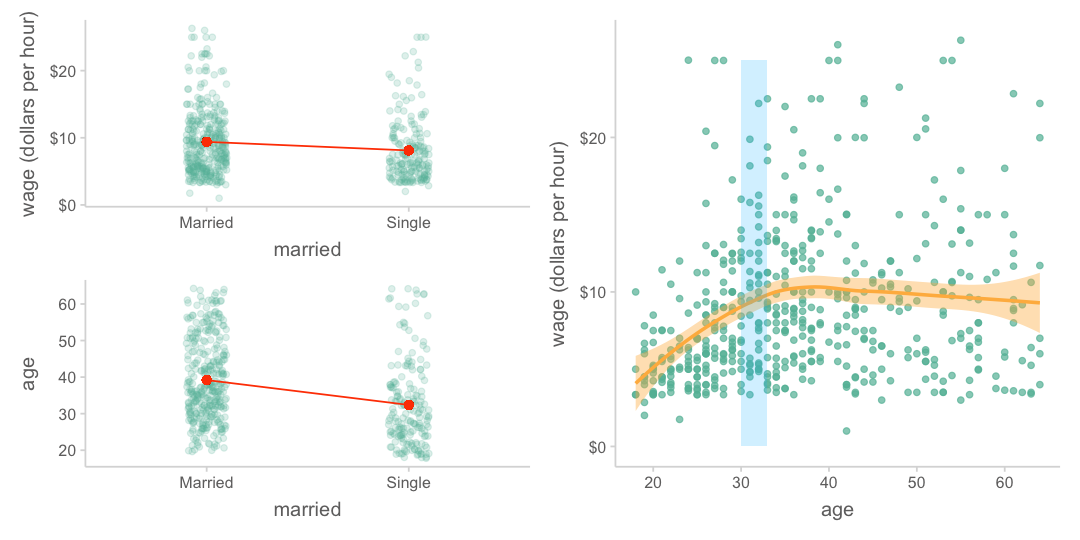

In [20]:
#| echo: false
#| warning: false

options(repr.plot.width = 9, repr.plot.height = 4.5, repr.plot.res = 120)

p1 <- cps2 |>
  add_predictions(mod1) |>
  ggplot(aes(x = married, y = wage)) +
  geom_jitter(width = .1, alpha = .2) +
  geom_point(aes(y = pred), color = "orangered", size = 2) +
  geom_line(aes(x = as.numeric(married), y = pred), color = "orangered") +
  scale_y_continuous(label = scales::label_dollar()) +
  labs(y = "wage (dollars per hour)")

mod2 <- lm(age ~ married, data = cps2)
p2 <- cps2 |> 
  add_predictions(mod2) |> 
  ggplot(aes(x=married, y=age)) +
  geom_jitter(width=.1, alpha=.2) +
  geom_point(aes(y=pred), color="orangered", size=2) +
  geom_line(aes(x=as.numeric(married), y=pred), color="orangered")

p3 <- cps2 |>
  ggplot(aes(x = age, y = wage)) +
  geom_point(alpha = .7) +
  geom_smooth() +
  annotate("rect", xmin = 30, xmax = 33, ymin = 0, ymax = 25, alpha = .2, fill = "deepskyblue") +
  scale_y_continuous(label = scales::label_dollar()) +
  labs(y = "wage (dollars per hour)")

(p1/p2) | p3

연령을 고려한 마라톤 기록?  
70세 노인의 기록 2시간 30분과 20세 청년의 2시간 30분은 마라톤 실력이라는 관점에서 다르게 볼 수도 있음  
예를 들어, "나이 차이가 큰 두 사람의 기록을 비교하는 것은 공평하지 않아"라는 주장에 대해서, 70세 노인의 기록은 "나이를 감안하면 2시간 10분에 해당한다"고 답변할 수 있음  
다시 말하면, 나이와는 **무관한/독립적인** 마라톤 능력에 대해 말할 수 있음  
이는 동일한 나이의 사람들로만 제한해서 마라톤 기록을 비교하는 것이 공평한 능력의 비교라고 말하는 것과 것이 같은 이치임

![](images/marathon.png){width=400}  
Source: [https://doi.org/10.1186/2052-1847-6-31](https://doi.org/10.1186/2052-1847-6-31)

### Case 2

기혼여부에 따른 임금의 차이가 남녀별로 다른가?  
연령이 올라감에 따라 임금이 올라가는 패턴에 차이가 있는가?

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


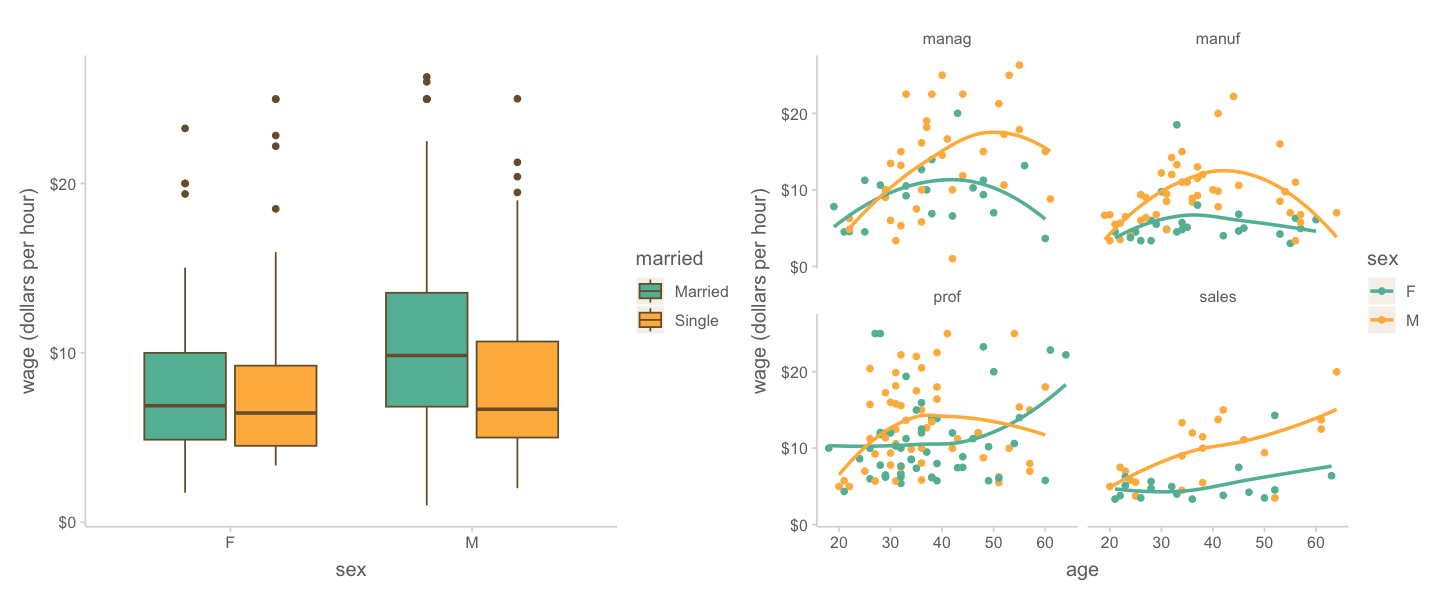

In [21]:
#| echo: false
#| warning: false
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 120)

mod3 <- lm(wage ~ married * sex, data = cps2)
p4 <- cps2 |>
    ggplot(aes(x = sex, y = wage, fill = married)) +
    geom_boxplot() +
    scale_y_continuous(label = scales::label_dollar()) +
    labs(y = "wage (dollars per hour)") +
    scale_color_brewer(palette = "Dark2")

p5 <- cps2 %>%
  filter(sector %in% c("manag", "manuf", "prof", "sales")) |>
  ggplot(aes(x = age, y = wage, color = sex)) +
  geom_point() +
  geom_smooth(se = FALSE, span = 1.5) +
  facet_wrap(~sector) +
  scale_y_continuous(label=scales::label_dollar()) +
  labs(y="wage (dollars per hour)")

p4 + p5

왼편 그림에서 보면, 기혼여부에 따른 임금의 차이가 남녀에 따라 다르게 나타나는 것으로 보임  
이러한 현상을 변수 간에 **상호작용(interaction)**이 있다고 말함 (moderate라는 표현도 있음)  
말하지면, 기혼여부가 임금에 주는 효과가 성별에 따라 바뀌고, 기혼여부와 성별이 상호작용하여 임금에 영향을 준다라고 표현할 수 있음 (2-way interaction)

비슷하게, 오른편을 보면, 연령에 따른 임금의 증가 패턴이 남녀에 따라서, 업종에 따라 다르게 나타나는 것으로 보임  
(manag: management, manuf: manufacturing, prof: professional)  
즉, 연령이 임금에 미치는 효과는 성별과 업종에 따라 바뀌고, 연령, 성별, 업종이 상호작용하여 임금에 영향을 준다라고 표현할 수 있음 (3-way interaction)

::: {.callout-warning}
위의 표현은 모두 효과를 가정한 표현으로 설명을 위해 편의상 그렇게 표현하였음  
또한, 다른 요소들은 단순화를 위해 생략했음. 예를 들어 왼편의 상황에서 나이를 고려하면 다른 양상을 보일 수 있음
:::

또 다른 예로는, 나이가 듦(age)에 따라 지구력(endurance)의 감소가 강도 높은 운동을 한 기간(년수)(exercise)에 따라 변화한다는 가설을 테스트한 자료

Rows: 245 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): age, exercise, endurance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


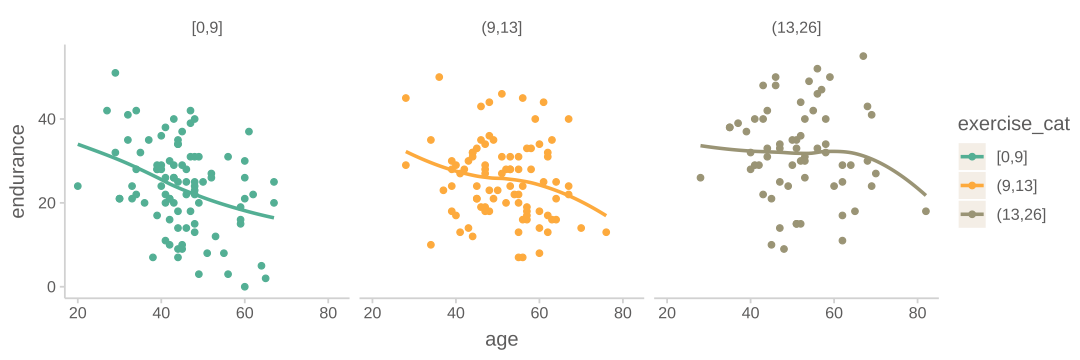

In [21]:
#| echo: false
#| warning: false
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 120)

acad2 <- read_csv("Cohen/data/C07E01DT.csv")
acad2 %>% 
  mutate(exercise_cat = cut_number(exercise, 3)) %>% 
  ggplot(aes(x = age, y = endurance, color = exercise_cat)) +
  geom_point() +
  geom_smooth(se = FALSE, span = 1) +
  facet_wrap(~exercise_cat)

이 경우 운동을 한 기간은 앞의 예에서처럼 카테고리 변수가 아니기 때문에 임의로 3구간으로 나누어 살펴 본 것임.  
나이가 지구력에 미치는 부정적 영향이 운동을 한 기간에 따라 변하는 것으로 보임.  
즉, 나이와 운동기간이 **상호작용**하여 지구력에 영향을 미친다고 표현할 수 있음

상호작용은 아래와 같이 상호작용하는 두 변수의 위치를 바꿔 살펴볼 수도 있음

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


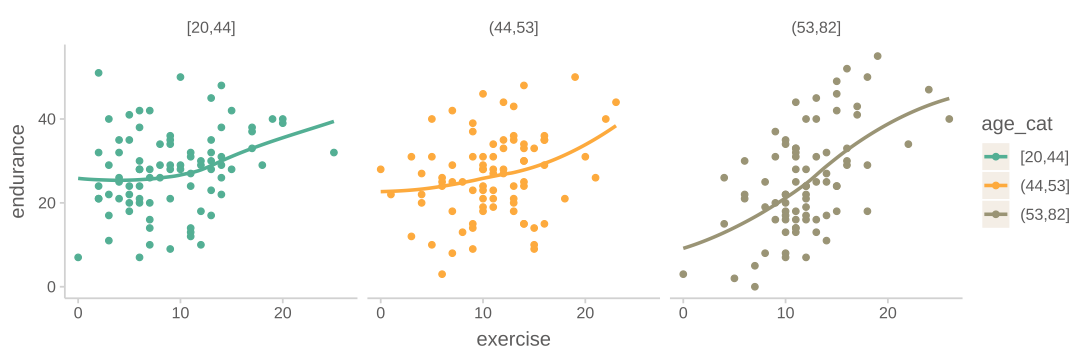

In [22]:
#| echo: false
#| warning: false
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 120)

acad2 %>% 
  mutate(age_cat = cut_number(age, 3)) %>% 
  ggplot(aes(x = exercise, y = endurance, color = age_cat)) +
  geom_point() +
  geom_smooth(se = FALSE, span = 1) +
  facet_wrap(~age_cat)

::: {.callout-important}
시각화를 통해 전반적인 패턴을 살펴보는 것은 통계적 모형을 세워 수학적으로 분석하기 전에 하는 보조 수단임.  
앞에 마라톤 기록의 예처럼 실제 분석은 한 변수를 고려한 후 다른 변수의 변화를 계산하는 방식으로 분석을 하는 것이지, 나이별로 자료를 나누어 보지 않듯이, 운동기간을 위에서처럼 구간으로 쪼개어 분석하는 것은 아님.
:::

### Case 3
임금이 증가하면 삶의 만족도가 높아지는가? 아마도?  

Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


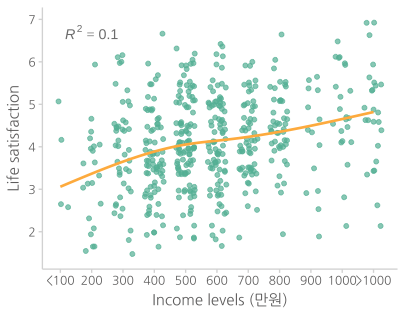

In [23]:
#| echo: false
#| warning: false
options(repr.plot.width = 4.5, repr.plot.height = 3.5, repr.plot.res = 90)

library(haven)
library(showtext)
font_add_google(name = "Nanum Gothic", family = "nanummj") # 폰트 이름, 이름 지정
showtext_auto()

df_ls <- read_sav("data/ls_data.sav")
colnames(df_ls) <- str_to_lower(colnames(df_ls))

ls <- df_ls |> 
  select(ls1_m1:ls5_m1, inc1_m1)

ls <- ls |> rowwise(inc1_m1) |> 
  mutate(ls = mean(c(ls1_m1:ls4_m1), na.rm = TRUE)) |> 
  ungroup()

ic <- c("<100", seq(200, 1000, 100), ">1000")

library(splines)
plot_ls <- ls |> 
  ggplot(aes(x = inc1_m1, y = ls)) +
  geom_jitter(width = .3, alpha = .7) +
  geom_smooth(method = "lm", 
              formula =  y ~ ns(x, 3),
              se = FALSE) +
  scale_x_continuous(breaks = seq(1, 11),
                     labels = ic) + 
  labs(x = "Income levels (만원)", y = "Life satisfaction") +
  ylim(1.4, 7) +
  theme(text = element_text(size = 12, family = "nanummj")) +
  annotate("text", 
           x = 2, y = 6.7,
           size = 4,
           label = "italic(R^2) == 0.1",
           color = "grey50",
           parse = TRUE)
plot_ls
mod <- lm(ls ~ ns(inc1_m1, 3), data = ls)


![](images/snu.png){width=400}  
하지만, 특정 A의 임금이 *p* 에서 *q* 로 증가할 때, 트렌드대로 움직이겠는가?  
혹은, 특정 B의 임금이 *r* 에서 *s* 로 감소할 때, 트렌드대로 움직이겠는가?  
개인의 변화를 살펴보는 **종단연구(logitudinal)**로 그 갭을 채울 수 있음

::: {.callout-note}
**Longitudinal** (종단) vs. **cross-sectional** (횡단)

종단 데이터는 관측의 단위, 예를 들어 개인을 반복측정하여 개개인의 특성을 함께 파악할 수 있는 장점을 가짐. 시간과 비용이 많이 들고, attrition (참여자 탈락) 비율이 높아질 우려가 있어 분석에 걸림돌이 되곤 함. 특히, 노인에 대한 연구는 사망으로 인해 참여자가 주는데, 이런 결측치를 고려한 분석에는 상당한 조심성과 기술이 요함. (missing data analysis)

분석의 관점에서 보면, 개인을 반복 측정하기 때문에 측정값들 사이의 **dependency** 문제가 생기는데 이를 분석에 고려하려는 노력임. 참여자 각각의 고유한 특성과 연구자가 측정하고자 하는 특성을 분리하고자 함. 위의 예에서 보면, "임금이 삶의 만족도에 주는 영향"과 "개개인의 고유한 특성이 삶의 만족도에 주는 영향"을 분리시켜야 전자의 효과를 분명히 파악할 수 있음. 이는 이후 언급할 multi-level analysis로도 볼 수 있음.

반면, 주로 접하게 되는 횡단 데이터는 모든 관측치가 **independent**, 즉 서로 영향을 받지 않는다고 가정할 수 있는데, 물론 한 가족의 구성원이 참여하는 연구는 그 가정에 위배됨.

횡단데이터의 문제는 소위 **cohort** bias가 숨어 있을 수 있음. 예를 들어 다른 나이대의 사람들은 다른 사회적 경험을 통해 다른 특성을 지녔을 수 있으므로, 데이터의 관측치들이 **homogenous** (동질적) 하지 못함으로 인해 연구자가 보려는 관계에 노이즈를 만들 수 있음.

:::

하지만, 그럴지라도 임금으로 **"인해"** 삶의 만족도가 올라가느냐는 다른 문제임 >> **인과관계**의 문제

- 예를 들어, 연봉의 증가가 삶의 만족도를 올렸다기 보다는 상대적 비교에서 오는 자존감이 증가했기 때문일 수 있음
- 연봉이 높은 곳은 직업 특성이 다를 수 있음
- 또는, 인맥과 인간관계의 변화에서 오는 차이일 수도 있음

다른 시각에서 보면,  
현재 A의 연봉 2천만원을 갑자기 4천만으로 올리면 삶의 만족도가 트렌드대로 0.8pt 올라가겠는가?  

- 연봉의 증가는 주변의 시기와 질투를 가져와 인관관계에 영향을 줄 수 있음  
- 본인의 자만은 여러 부정적 결과를 초래할 수 있음


#### **Prediction vs. intervention**

- A의 임금이 **올라가면** 삶의 만족도가 따라서 올라갈 것이라고 (조심스럽게) **예측**할 수는 있으나: **association**  
  - 좀 더 정확히 말하면, 임금이 높은 것은 삶의 만족도가 높은 것과 연관이 있다라고 표현
  - "올라가면"이라는 표현은 시간 개념을 포함한 것이라 횡단(cross-sectional) 데이터에서는 부적절
- A의 임금을 **올리면** 삶의 만족도가 올라갈 것이라고 단정할 수 없음: **causal**
- **Intervention이** 효과가 있으려면, 적어도 진정한 관계를 파악해야만 하며, 더 나아가 인과관계가 만족해야 함.
- 진정한 관계의 문제와 인과의 문제는 서로 엮여 있으며 복잡한 문제임.
  - 예를 들어, 오렌지를 섭취하면 괴혈병이 예방되나 사실은 비타민 C의 섭취가 괴혈병을 예방하는 것임  
    만약, 장거리 항해에서 상급자(높은 연령)에게만 과일이 제공되었을 때, 나이가 많은 선원들에게서 괴혈병이 덜 생겼다는 현상으로부터 연령과 괴혈병의 관계를 추론해서는 안됨. 하지만 예측은 여전히 유효함.    
    ![](images/mediation.png){width=320}   
  - 또는, 신앙심이 깊은 노인들의 수명이 더 길다는 현상이 관찰되었을 때, 신앙심 자체가 심리적으로나 신체적으로 긍정적인 효과를 가질 수 있으나, 그 외에도 신앙 활동의 일부로 활동이 늘고 다른 이와의 긍정적 교류가 건강에 영향을 미쳤을 수도 있음.  
    ![](images/indirect.png){width=340}  
    이 때, 신앙심과 수명과는 진정한 관계가 있다고 볼 수 있으나 (not spurious) 그 인과 관계에 대해서도 좀 더 깊은 논의가 필요함.  
    다시 말하면, 어떤 노인에게 신앙을 권유했을 때, 수명이 연장되었을지라도 신앙심이 수명을 연장시킨 것인가는 별개의 논의임.

#### **The strength of relationships**  
변수들간의 관계와 그 관계의 크기(stength)는 중요하게 구별될 필요가 있음  
아래 두 그림은 변수 간의 관계는 동일하나 그 크기에 차이가 있음  
오른쪽 그림에서 연봉으로 그 사람의 삶의 만족도 지수를 더 정확히 예측할 수 있으며, 이를 설명력 $(R^2)$이 높다고 표현  
보통 이 효과의 크기가 클수록 인과관계일 가능성은 높다고 볼 수 있으며,  
왼쪽 박스에서처럼 variability가 높다는 것은 다른 이유가 있을 가능성이 높음

Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


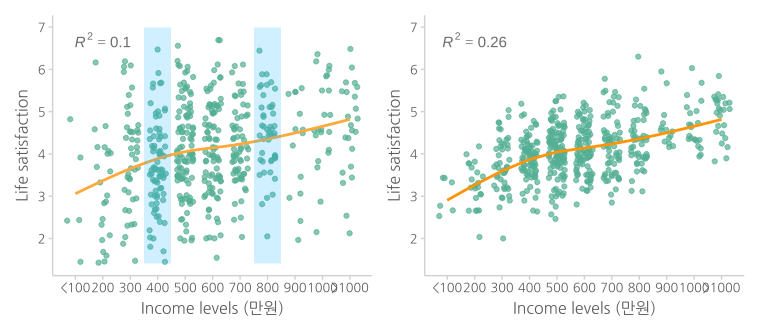

In [24]:
#| echo: false
#| warning: false
options(repr.plot.width = 8, repr.plot.height = 3.5, repr.plot.res = 95)

mod <- lm(ls ~ ns(inc1_m1, 3), data = ls)

library(modelr)
ls <- ls |> 
  add_predictions(mod)

ls <- ls |>
  mutate(e = pred + rnorm(519, 0, 0.6))

mod3 <- lm(e ~ ns(inc1_m1, 3), data = ls)

plot_ls2 <- ls |>  
  ggplot(aes(inc1_m1, e)) +
  geom_jitter(width = .3, alpha = .7) +
  geom_line(aes(y = pred), color = "orange", linewidth = 1) +
  scale_x_continuous(breaks = seq(1, 11), labels = ic) +
  labs(x = "Income levels (만원)", y = "Life satisfaction") +
  ylim(1.4, 7) +
  theme(text = element_text(size = 12, family = "nanummj")) +
  annotate("text", x = 2, y = 6.7, size = 4,
      label = paste("italic(R^2) ==", round(summary(mod3)$r.squared, 2)),
      color = "grey50", parse = TRUE)

plot_ls1 <- plot_ls +
  annotate("rect", xmin = 3.5, xmax = 4.5, ymin = 1.4, ymax = 7, alpha = .2, fill = "deepskyblue") +
  annotate("rect", xmin = 7.5, xmax = 8.5, ymin = 1.4, ymax = 7, alpha = .2, fill = "deepskyblue")
plot_ls1 + plot_ls2

::: {.callout-note}
진정한 관계를 탐구하는 것이 어려움에도 불구하고, 관계성을 파악함으로써 통찰을 얻을 수 있음.

<iframe src="https://ourworldindata.org/grapher/children-per-woman-fertility-rate-vs-level-of-prosperity" loading="lazy" style="width: 100%; height: 600px; border: 0px none;"></iframe>

:::

복잡한 변수와의 관계를 풀어내려고 노력  
Source: *Multiple Regression and Beyond* by Timothy Z. Keith

::: {layout-ncol=2}
![](images/path1.png)

![](images/path4.png)
:::

![](images/latent.png){width=650}
<br />

## Causal: 인과관계의 분석
위에서 살펴본 것들은 모두 연구자가 개입하지 않고 관찰만으로 이루어진 분석들임  
논의한 것처럼 관찰된 자료로부터 진실된 관계를 파악하는 것은 매우 정교한 분석이 요구되고 많은 요소들을 고려해야 함.  
좀 더 분명한 관계를 파악하기 위해 실험 연구가 요구되곤 함  
하지만, 많은 경우 실험이 불가능할 뿐 아니라,  
실험이 반드시 최선인 것은 아니며, 실험은 나름데로 큰 약점을 갖고 있음.

::: {.callout-important}
# **Confounding**
일반적으로, 표면적으로 드러난 변수간의 관계가 숨겨진 다른 변수(lurking third variable)에 의해 매개되어 있어 진실한 관계가 아닌 경우, confounding 혹은 confounder가 존재한다고 함.  
사회과학에서 오래된 가장 핵심적인 문제이나 최근까지도 정확히 정의하기 어려움 개념이었음.  
**Causal analysis**라는 통계와는 별개의 개념으로 발전되어 최근에야 이론적으로 완성이 되어 관심이 높아짐.

극단적이지만 이해하지 쉬운 예로는  

- 초등학생 발 사이즈 &rarr; 독해력  
- 머리 길이 &rarr; 우울증
:::

::: {.callout-note collapse=true}
### Answer!
![](images/confounding.png){width=450}
:::

맨 처음 든 예도 마찬가지로 &emsp; ![](images/path3.png){width=210}

올바른 관계를 파악하려면, 동일한 나이에 대해 그 관계를 파악한 후 각 나이에서의 효과를 (weighted) 평균해서 살펴봐야함  

통계에서는 이를 나이를 **통제 (control for age)**한다고 표현하며, 같은 의미로 다음과 같은 표현을 씀   
나이를 **고려**했을 때; **account for** age  
나이를 **조정**했을 때; **adjust for** age  
나이를 **잔차화**했을 때; **residualize** age  
나이의 변량을 넘어서서; **above and beyond** age

**Simpson's paradox**

아래 첫번째 그림은 집단 전체에 대한 플랏이고, 두번째 그림은 나이대별로 나누어 본 플랏  
전체 집단을 보면 운동을 많이 할수록 콜레스테롤이 증가하는 것으로 보이나,  
나이대별로 보면, 상식적으로 운동이 긍정적 효과가 나타남.  
왜 그렇게 나타나는가?

![](images/simpson.jpg){width=600}  
Source: *The book of why* by Judea Pearl

관찰 데이터로부터 진정한 관계를 파악하기 위해서는 이와 같은 **통계적인 통제**를 통해 혹은 **인과분석**이라는 좀 더 큰 프레임에서 분석해야 하며, 깊은 논의가 필요함

마지막 예를 들면,  
은퇴한 노인들을 대상으로 규칙적인 걷기가 사망율을 감소시킬 것이라는 가설을 확인하기 위해 1965년 이후 8000명 가량의 남성들을 추적조사한 데이터의 일부를 이용했는데,  
Source: *The book of why* by Judea Pearl

- 12년 후 사망율에서 casual walker(하루 1마일 이하)와 intense walker(하루 2마일 이상)가 각각 43%, 21.5%로 나타났음.
- 이 걷기의 효과를 의심케 하는 요소들(**confounding**)은 무엇인가?

::: {.callout-note collapse=true}
### Answers!

- 건강이 나빠 많이 걷지 못했을 수도...
- 많이 걷는 사람은 상대적으로 젊을 수도...
- 많이 먹는 사람이 덜 걸을 수도...
- 술을 많이 먹는 사람이 덜 걸을 수도...
:::

::: {.callout-important}
무수히 많이 생각해볼 수 있는 confounding 요소들을 다 고려해야 하는가?  
Yes and No!  

실제 저자들도 다음과 같이 기술  
“Of course, the **effects** on longevity of intentional efforts to increase the distance walked per day by physically capable older men **cannot be addressed** in our study.”

이러한 조심성은 의미있느나 너무 과장될 필요는 없음  
소위 중요 역할을 할 것으로 의심되는 confounding을 충분히 통계적으로 고려/통제했다면, 충분히 인과관계 혹은 intervention을 제안할 수 있으며,  
그러한 연구는 어떤 요소들을 고려했는지에 대해 밝힘으로써 추후 연구에서 어떤 부분이 더 추가적으로 고려되야 할지 알 수 있게 함.
:::

앞서 살펴본 관찰 연구들이 모두 confounding의 위험을 안고 있기에 결정적인 인과관계를 파악하기 위해,
전통적으로 "통계학"의 시각에서 인과문제에 대해서는 보통 임상테스트에서 실시하는 RCT (randomized controlled trial)라고 부르는 소위 gold standard한 **실험 연구**를 통해서 해결하고자 했음  
개념적으로는 **물리적 통제**라고 볼 수 있으며, 두 그룹으로 집단을 **randomly assign**(무선/무작위 배정/할당)하면 모든 면에서 동질한 성향을 가짐. 예를 들어, 두 집단의 연령이 평균적으로 동일해짐.  
<br />

   ![](images/RCT.png){width=400}  

   Source: [*The whats and whys of RCTs*](https://blogs.kcl.ac.uk/behaviouralinsights/2017/11/20/the-whats-and-whys-of-rcts-part-1/)

앞서 든 예에서, 걷기가 사망율에 미치는 효과를 검증하려면, 가령 600명을 300명씩 두 그룹으로 무작위로 나눈 후 한쪽은 1마일 이하를 걷도록 하고 나머지는 2마일 이상을 걷게 한 후 12년 후 사망율을 확인해야 함.

분야마다 효과를 제대로 검증하기 위한 많은 실험 설계들이 발전되었음 >> 연구방법론

그럼에도 불구하고, 실험 연구는 자체로 한계를 지님

- 많은 경우 실험이 불가능하며
- 실험에서 처치한 구체적인 상황에서만 유효하고
- 그 효과는 어떻게 표현할 것인가?

### Case 1
Terror Management Theory (TMT)  
Self-esteem의 이론적 근거를 밝히고자 함. 왜 인간은 self-esteem을 유지하려는가?  

![](images/TMT.png){width=400}

Treatment: 자신의 죽음과 고통에 대해 생각해보고 써보도록 하고  
Control: 자신의 치통에 대한 질문에 답  

측정: 고정관념에 대해 부정적으로 말하는 사람을 어떻게 평가하는가?  
결과: 그들을 더 부정적으로 평가: defences their own culural worldview  
(e.g. *Stereotypes and Terror Management: Evidence That Mortality Salience Enhances Stereotypic Thinking and Preferences*)

- 죽음이나 치통에 대한 생각은 모두 두려움을 포함해 부정적 감정을 불러 일으키는데
- 그저 두려움에 대한 반응인가? 아니면 정확히 "죽음에 대한 생각"이 효과를 만든 것인가?
- 참여자들의 부정적 정서를 실험 마지막에 측정한 후 분석에 고려했음  

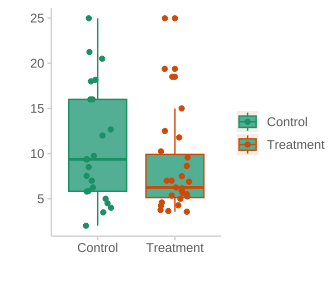

In [25]:
#| echo: false
#| warning: false
options(repr.plot.width = 3.5, repr.plot.height = 3, repr.plot.res = 95)

set.seed(123)
cps2 |>
  sample_n(50) |> 
  mutate(sex = ifelse(sex == "F", "Treatment", "Control")) |>
  ggplot(aes(x = sex, y = wage, color = sex)) +
  geom_boxplot() +
  geom_jitter(width=.2) +
  labs(y = "", x = "", color = "") +
  scale_color_brewer(palette = "Dark2")


::: {.callout-important}
연구 설계시 관심이 있는 효과를 효과적으로 측정하는 것과 동등하게 중요한 것은 어떤 **confounding**들이 존재할 수 있는지를 다각도로 검토한 후 이를 설계에 반영하는 것임.  
예를 들어, 위의 경우 죽음에 대한 생각 자체의 효과가 아닌 죽음을 생각했을때 발생할 수 있는 부수적인 감정들로 인해 효과가 난 것이 아닌가하는 것들을 고려해서 설계할 수 있음.
:::

### Case 2

마시멜로우 실험, 1960's

![](images/marshmallow2.png){width=400}  
Source: [Want To Teach Your Kids Self-Control?](https://www.npr.org/sections/goatsandsoda/2017/07/03/534743719/want-to-teach-your-kids-self-control-ask-a-cameroonian-farmer)

3-5세 아이들에게 마시멜로우 1개를 놓고 원하면 먹도록 하나, 만약, 5분을 안먹고 기다리면 2개를 먹을 수 있다고 말한 후, 기다리지 못하고 먹는지를 살펴봄

소위 **delay gratification**을 self-control을 발휘한 것으로 이해했으며, 먹지 않고 기다린 아이들이 추후에 학업성취도 및 여러면에서 뛰어난 결과를 보고 하였음.

- 아이들이 참고 기다린 것은 자력에 의한 자기통제력인가?
- 어른들 즉, 권위에 대한 복종인가?
- 더 많이 먹기 위한 욕심인가?
- 눈 앞에 이익을 빨리 취하는 것은 좋은 전략일 수 있지 않은가?

혹시 실험을 진행하는 실험자에 따라 다른 효과가 나타날까? (Experimenter effects)  
처치(treatment)의 효과인가 처지가 일어나는 **상황이** 만든 효과인가?

::: {.callout-important}
이 연구에서도 여러 **confounding**들을 생각해볼 수 있음  
위에서 언급한 것들 외에 어떤 것들이 있을까?
:::

적어도 마시멜로우 실험의 경우에서 아이들에게 기다리라고 지시한 experimenter들의 정보를 고려할 필요가 있음.  
그럼, 각 experimenter별로 자료를 분석해야 하는가?

좀 더 확장하면,

- 같은 처방을 내린 의사들에 따라 다른 효과가 나타날까?  
- 의사가 속한 병원마다 다른 효과가 나타날까?  
- 특정 수업방식의 효과가 학교마다 선생님마다 다르게 나타날까?

::: {.callout-note}
**Multi-level analysis** (mixed effect model)

이는 위에서 언급한 longitudinal (종단) 데이터가 지닌 관측치의 **dependency**를 고려하는 일반적인 접근임. 관측치들이 군집을 이루면서 군집끼리 비슷한 경향을 보인다면, 이를 고려한 분석이 요구됨. 보통 dependency는 데이터를 어떻게 수집했는지를 알아야 파악할 수 있으며, 데이터 내에서 찾아내기 어려움. (clustering analysis 같은 machine learning 분야에서 개발되는 알고리즘적 분석들이 있음)  

만약, 군집을 이루는 단위가 충분히 많다면,  
예를 들어, 10개의 병원에서 30명의 의사가 각각 50명의 환자에게 새롭게 개발된 처방을 처치하여 그 효과를 볼 때,

- 병원의 효과 vs. 의사의 효과 vs. 처치의 효과를 분리하여 좀 더 분명한 효과를 찾을 수 있음

또는, 30개의 학교에서 50명의 선생님들이 30명의 학생들에게 특정 수업방식의 효과를 검증할 때,

- 학교의 효과 vs. 선생님의 효과 vs. 수업의 효과를 분리해 볼 수 있음

**분석을 위해 각 선생님 마다 혹은 학교마다 따로 분석하는 것도 아니며, 학교별 혹은 선생님별 특성을 측정하여 고려한다든가 하는 방식이 아님.** 자료가 품고 있는 관측치들의 유사성이 통계적으로 파악되어 고려되는 것으로, 모든 샘플을 동시에 이용한 고급 통계 방법

사회과학 자료에서도 만일 가족단위로 데이터 수집이 이루어진다면, 가족 간의 무언가 톡특한 특성이 연구결과에 반영될 수 밖에 없는데, 가족의 특성을 분리해야 연구자가 살펴보는 관심 변수들 간의 관계를 올바로 파악할 수 있음. 다시 지적하면, 연구에서 가족의 특성을 직접 측정해서 고려한다는 의미가 아니고, 자료가 품고 있는 가족간의 유사성이 통계적으로 파악되어 고려되는 것임.
:::

## Uncertainty

관찰자가 관찰한 대상으로부터 얻은 결과를 관찰하지 않은 더 넓은 대상으로 일반화할 수 있는가?  
가령, 다음과 같이 150명에 대해 조사한 "연령이 임금에 미치는 효과"를 일반화 할 수 있는가?  
한 나라의 국민 전체?

`geom_smooth()` using formula = 'y ~ x'


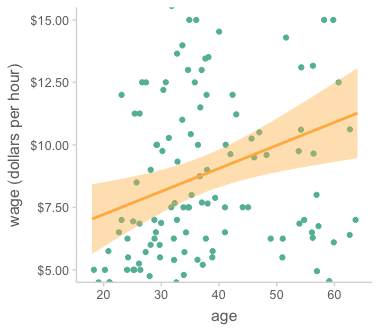

In [23]:
#| echo: false
#| warning: false
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 95)

set.seed(123)
cps3 <- cps |> 
  filter(wage < 30) |> 
  sample_n(150)
  
mod_age <- lm(wage ~ age, cps3)
cps_boot <- Boot(mod_age, R=20)
boot_df <- as_tibble(cps_boot$t)
boot_df <- boot_df |> 
  rename(c = '(Intercept)', a = age)

cps_150 <- cps3 |>
  ggplot(aes(x = age, y = wage)) +
  geom_jitter() +
  geom_smooth(method = lm) +
  coord_cartesian(ylim = c(5, 15)) +
  scale_y_continuous(label=scales::label_dollar()) +
  labs(y="wage (dollars per hour)")

cps_150

**Statistical inference** (통계적 추론)

통계학의 추론(statistical inference)은 작은 샘플(sample)로부터 얻은 분석 결과를 바탕으로 모집단(population)이라고 부르는 전체에 대해 말하고자 하는 시도에서 비롯되었음

- 어떤 비료가 특정 콩 A의 재배에 어떤 영향을 미치는지 알기 위해 하나의 sample (N=10000: sampe size) 위에서 실험이 이루어지고, 그 결과가 A라는 콩의 종 전체에 얼마나 적용될 수 있을지를 알아보고자 했음  
- 사람에게도 적용될 수 있는가?

사실상 난해한 통계 이론의 상당부분을 차지함.  
하지만, 통계적 추론의 논리는 개념적으로는 다음과 같이 볼 수 있음.

앞서 논의한 모든 내용은 "특정 샘플" 내에서 변수들 간의 관계에 대한 분석일 뿐 그 샘플을 벗어나서 논의한 것이 아님. 
통계적 추론은 수많은 같은 수의 샘플들, 가령 N = 150인 즉, 150명으로 이루어진 샘플들을 반복적으로 관찰한다면 그 샘플들 간의 편차들이 어떠하겠는가에 대한 논의임.    

- 첫번째 그림에서처럼 (알수는 없지만) 어떤 population을 가정하는데, 그 모집단에는 age와 wage의 true relationship이 선형적으로 존재한다고 가정함. 연구자가 한번에 150명으로 이루어진 sample을 반복적으로 관찰한다면, 샘플마다 age와 wage의 관계는 다르게 나타날 것임 (두번째 그림). 
- 예를 들어, 그 기울기에 관심이 있다면, 샘플들로부터 나타나는 기울기들의 분포를 살펴봄으로써 (세번째 그림) 샘플에서 나타날 수 있는 기울기값이 어떠한가를 파악할 수 있음.  
- 이 분포를 **sampling distribution**이라고 부름
- 이 분포에 따르면 평균이 0.066이고, 기울기 값들의 95%가 0.005 ~ 0.140 범위에 있음을 알 수 있음.
- 다시말하면, 연구자가 관찰한 샘플로부터 연구자는 (age와 wage의 선형성을 가정한다면), 매우 큰 확신을 갖고 나이가 10세 늘때마다 시간당 임금의 증가율은 0.05에서 1.4달러 사이에 있을 것이라고 말할 수 있음.
- 확신이 커지려면 임금증가율의 범위가 넓어져야 함. 예를 들어, 99%의 확신을 갖고 나이가 10세 늘때 시간당 임금의 증가율은 -0.18에서 1.67달러 사이에 있을 것이라고 말할 수 있음. 별로 의미없는 발언이 될 수 있음.
- 반대로, 확신에 대해서는 양보하는 대신 임금증가율에 대한 범위폭을 줄일 수 있음. 예를 들어 90%의 조금 낮은 확신을 갖고 임금증가율은 0.14에서 1.3달러 사이에 있을 것이라고 말할 수 있음

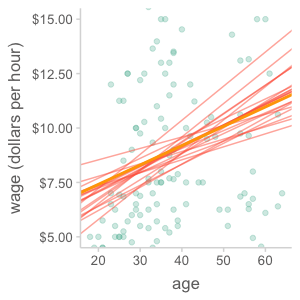

In [25]:
#| echo: false
#| output: false
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)

cps3 |>
  ggplot(aes(x = age, y = wage)) +
  geom_point(alpha = 0.3) +
  geom_abline(data = boot_df, aes(intercept = c, slope = a), alpha = .5, color = "tomato") +
  geom_abline(intercept = 5.63, slope = 0.089, color = "orange", linewidth = 1) +
  coord_cartesian(ylim = c(5, 15)) +
  scale_y_continuous(label = scales::label_dollar()) +
  labs(y = "wage (dollars per hour)")

ggsave("images/bootstrap.png", width=4, height = 4, dpi=100)

::: {layout-ncol=2}

![](images/sampling.png){width=420}  
Source: *The Truthful Art* by Albert Cairo.

![](images/bootstrap.png){width=380}
:::

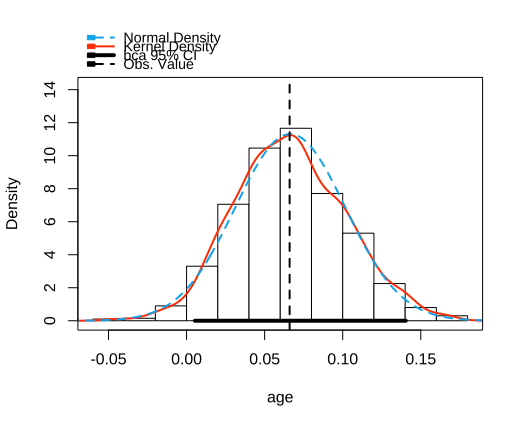

In [72]:
#| echo: false
#| layout-ncol: 2
options(repr.plot.width = 5.5, repr.plot.height = 4.5, repr.plot.res = 95)

set.seed(123)
cps_boot2 <- Boot(mod_age, R=999)
plot_hist <- hist(cps_boot2, parm = "age", den.col = "orangered", nor.col = "deepskyblue2", col = "white")

In [73]:
#| echo: false
Confint(cps_boot2) %>% round(., 3) |> print()

Bootstrap bca confidence intervals

            Estimate 2.5 % 97.5 %
(Intercept)    6.563 3.926  8.908
age            0.066 0.005  0.140


::: {.callout-note}
위와 같이 어떤 분포를 가정하고 파라미터(기울기 등등)를 포함해 상정한 모델에 대한 통계적 추정과 추론을 하는데 대한 비판이 오래전부터 있어왔음. 현실의 실제적 현상에 적용할 때는 이론적인 통계의 원리와는 별개의 더 깊은 논의가 필요함.  
e.g:  
Breiman, L. (2001). Statistical modeling: The two cultures (with comments and a rejoinder by the author). Statistical science, 16(3), 199-231.  
Wasserstein, R. L., & Lazar, N. A. (2016). The ASA statement on p-values: context, process, and purpose. The American Statistician, 70(2), 129-133.  
Pearl, Judea, and Dana Mackenzie. 2018. The Book of Why: The New Science of Cause and Effect. Basic books.
:::

## Regression analysis  
앞서 다뤘던 임금과 연령의 관계에 대한 간단한 회귀 분석의 예들
<br>

1. 선형 관계를 가정한 **임금과 연령의 관계**에 대한 회귀분석 (N=150)

`geom_smooth()` using formula = 'y ~ x'


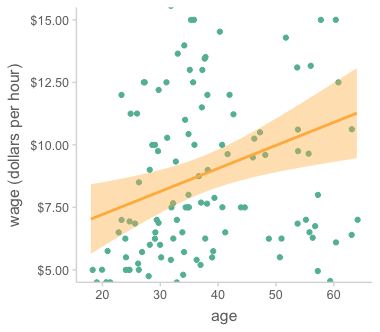

In [26]:
#| echo: false
#| warning: false
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 95)
cps_150

Model: `lm(wage ~ age, data = cps)`

In [27]:
#| echo: false
lm_mod <- lm(wage ~ age, data = cps3)
summ(lm_mod, confint=TRUE, digit=3)

MODEL INFO:
Observations: 150
Dependent Variable: wage
Type: OLS linear regression 

MODEL FIT:
F(1,148) = 8.755, p = 0.004
R<U+00B2> = 0.056
Adj. R<U+00B2> = 0.049 

Standard errors: OLS
----------------------------------------------------------
                     Est.    2.5%   97.5%   t val.       p
----------------- ------- ------- ------- -------- -------
(Intercept)         5.375   2.970   7.780    4.417   0.000
age                 0.092   0.031   0.154    2.959   0.004
----------------------------------------------------------

<br>

2. 맨 처음 든 예, 즉 **연령을 고려한/통제한** "기혼여부에 따른 임금차이"를 회귀분석하면 (N=465)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


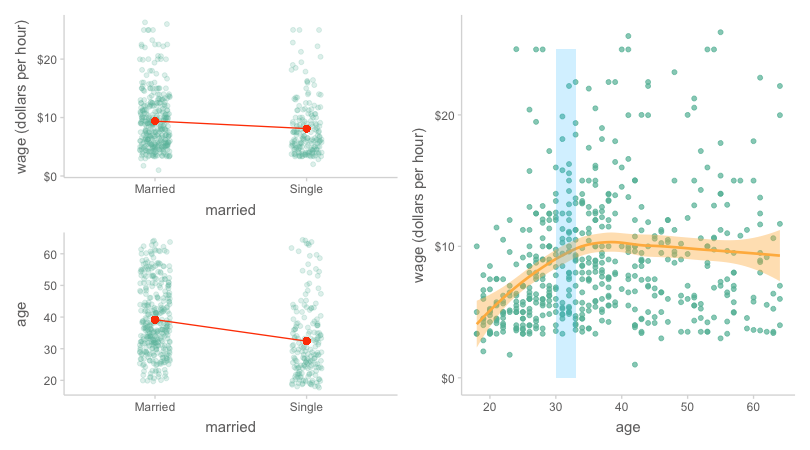

In [28]:
#| echo: false
#| warning: false
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 90)

(p1 / p2) | p3

우선, 결혼여부에 따른 평균 임금의 차이는 미혼일 때 -0.97 (dollars/hr) 낮음.  
하지만, 모집단에서 그 차이는 (95% 확률로) -1.93에서 -0.02 사이에 있을 것이라고 추정할 수 있음

Model: `lm(wage ~ married, data = cps)`

In [29]:
#| echo: false
lm_mod2 <- lm(wage ~ married, data = cps2)
summ(lm_mod2, confint = TRUE, digit = 2)

MODEL INFO:
Observations: 533
Dependent Variable: wage
Type: OLS linear regression 

MODEL FIT:
F(1,531) = 8.34, p = 0.00
R<U+00B2> = 0.02
Adj. R<U+00B2> = 0.01 

Standard errors: OLS
-----------------------------------------------------------
                       Est.    2.5%   97.5%   t val.      p
------------------- ------- ------- ------- -------- ------
(Intercept)            9.40    8.89    9.91    36.07   0.00
marriedSingle         -1.28   -2.16   -0.41    -2.89   0.00
-----------------------------------------------------------

::: {layout-ncol=2}
앞서 논의한데로 나이가 **confounding**이 될 수 있고,  
이를 통계적으로 통제하면,

![](images/path3.png){width=210}
:::

Model: `lm(wage ~ married + sex + age + I(age^2), data = cps)`

In [30]:
#| echo: false
lm_mod3 <- lm(wage ~ married + sex + age + I(age^2), data = cps2)
summ(lm_mod3, confint=TRUE, digit=2)

MODEL INFO:
Observations: 533
Dependent Variable: wage
Type: OLS linear regression 

MODEL FIT:
F(4,528) = 23.70, p = 0.00
R<U+00B2> = 0.15
Adj. R<U+00B2> = 0.15 

Standard errors: OLS
------------------------------------------------------------
                       Est.     2.5%   97.5%   t val.      p
------------------- ------- -------- ------- -------- ------
(Intercept)           -6.43   -10.87   -2.00    -2.85   0.00
marriedSingle         -0.17    -1.04    0.70    -0.38   0.70
sexM                   2.44     1.67    3.22     6.18   0.00
age                    0.68     0.46    0.91     5.95   0.00
I(age^2)              -0.01    -0.01   -0.00    -5.26   0.00
------------------------------------------------------------

"나이를 고려했을 때", 미혼이 기혼보다 그 임금이 0.17 (dollars/hr) 낮은데,  
모집단에서 그 차이는 -1.04 ~ 0.70 사이에 있을 확률이 매우 높은 것으로 추론됨. (95% 확률로)  
이는 사실상 임금 차이가 있다고 볼 확신을 거의 갖기 어려움

결혼여부와 성별이 **상호작용**하는 것을 고려하고, 임금의 분포를 고려해서 log 변환하면,

Model2: `lm(log_wage ~ married * sex + age + I(age^2), data = cps)`

In [46]:
#| echo: false
cps2 <- cps2 |>
    mutate(log_wage = log(wage)) |> 
    filter(log_wage > 1)

lm_mod4 <- lm(log_wage ~ married * sex + age + I(age^2), data = cps2)
summ(lm_mod4, confint = TRUE, digit = 2)

MODEL INFO:
Observations: 530
Dependent Variable: log_wage
Type: OLS linear regression 

MODEL FIT:
F(5,524) = 25.06, p = 0.00
R<U+00B2> = 0.19
Adj. R<U+00B2> = 0.19 

Standard errors: OLS
----------------------------------------------------------------
                            Est.    2.5%   97.5%   t val.      p
------------------------ ------- ------- ------- -------- ------
(Intercept)                 0.23   -0.23    0.68     0.98   0.33
marriedSingle               0.07   -0.05    0.20     1.17   0.24
sexM                        0.34    0.24    0.43     6.82   0.00
age                         0.08    0.06    0.11     7.06   0.00
I(age^2)                   -0.00   -0.00   -0.00    -6.45   0.00
marriedSingle:sexM         -0.21   -0.38   -0.05    -2.51   0.01
----------------------------------------------------------------

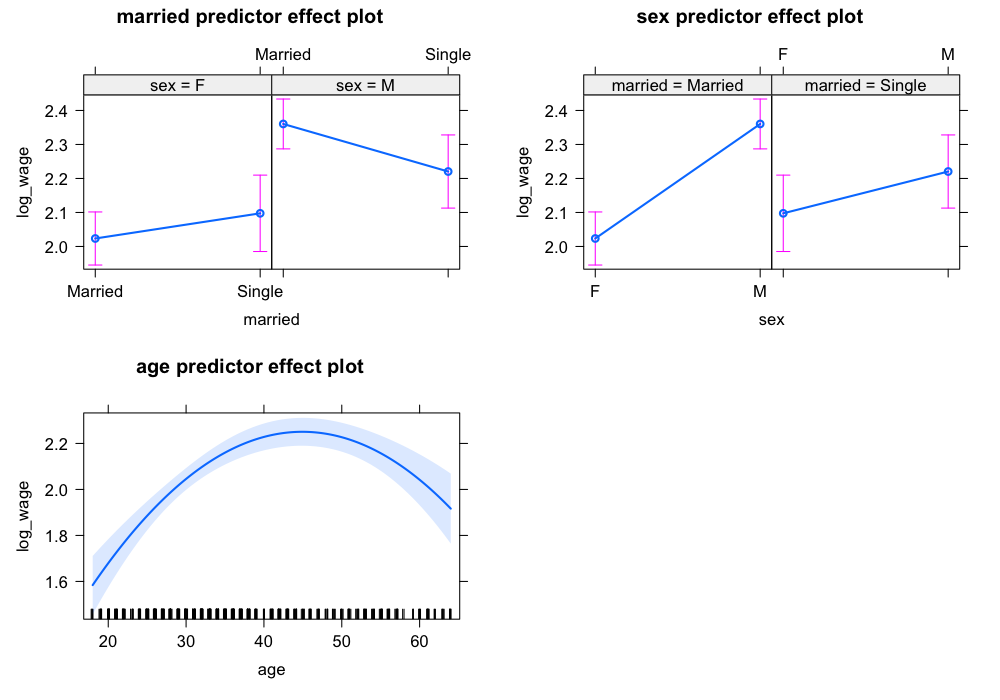

In [36]:
#| echo: false
#| warning: false
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 100)
library(effects)
library(car)
plot(predictorEffects(lm_mod4))

::: {.callout-note}
나이와 임금의 관계가 위의 플랏에서 나타났듯이 35세부터 일정하게 유지되는 패턴을 보이므로 그 비선형성을 단순화하여 2차 함수 꼴$(y=c+b\cdot age+a\cdot age^2)$로 모델링을 하였으나 원칙적으로는 다른 모형이 필요함
:::

# 그 외

종속변수가 연속변수라고 볼 수 없는 경우들

- 완치 여부: success vs. fail
- 구매 여부: yes vs. no
- 사건 또는 사람의 수 (count)